In [279]:
# Goals:
# * Explore auto/X/Y trends
# * Explore chr13 trend as a function of repeat length

# Questions:
#    why not 18.119 unique loci here?

In [4]:
import pandas as pd
#import sklearn.decomposition
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
#import seaborn as sns
import math
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from sklearn.linear_model import LogisticRegression
import random
from operator import itemgetter

# Load data

In [13]:
nucToNumber={"A":0,"C":1,"G":2,"T":3}

def GetCanonicalMotif(repseq):
    r"""Get canonical STR sequence, considering both strands
    The canonical sequence is the first alphabetically
    out of all possible rotations on + and - strands
    of the sequence. e.g. "TG" canonical sequence is "AC".
    Parameters
    ----------
    repseq : str
          String giving a STR motif (repeat unit sequence)
    Returns
    -------
    canon : str
          The canonical sequence of the STR motif
    Examples
    --------
    >>> GetCanonicalMotif("TG")
    "AC"
    """
    repseq = repseq.upper()
    # Get canonical sequence of each strand
    repseq_f = GetCanonicalOneStrand(repseq)
    repseq_r = GetCanonicalOneStrand(ReverseComplement(repseq))
    # choose first seq alphabetically
    for i in range(len(repseq_f)):
        if nucToNumber[repseq_f[i]] < nucToNumber[repseq_r[i]]:
            return repseq_f
        if nucToNumber[repseq_r[i]] < nucToNumber[repseq_f[i]]:
            return repseq_r
    return repseq_f

def GetCanonicalOneStrand(repseq):
    r"""Get canonical STR sequence, considering one strand
    The canonical sequence is the first alphabetically
    out of all possible rotations. e.g. CAG -> AGC.
    Parameters
    ----------
    repseq : str
          String giving a STR motif (repeat unit sequence)
    Returns
    -------
    canon : str
          The canonical sequence of the STR motif
    Examples
    --------
    >>> GetCanonicalOneStrand("CAG")
    "AGC"
    """
    repseq = repseq.upper()
    size = len(repseq)
    canonical = repseq
    for i in range(size):
        newseq = repseq[size-i:]+repseq[0:size-i]
        for j in range(size):
            if nucToNumber[newseq[j]] < nucToNumber[canonical[j]]:
                canonical = newseq
            elif nucToNumber[newseq[j]] > nucToNumber[canonical[j]]:
                break
    return canonical

def ReverseComplement(seq):
    r"""Get reverse complement of a sequence.
    Converts everything to uppsercase.
    Parameters
    ----------
    seq : str
          String of nucleotides.
    Returns
    -------
    revcompseq : str
          Reverse complement of the input sequence.
    Examples
    --------
    >>> ReverseComplement("AGGCT")
    "AGCCT"
    """
    seq = seq.upper()
    newseq = ""
    size = len(seq)
    for i in range(len(seq)):
        char = seq[len(seq)-i-1]
        if char == "A":
            newseq += "T"
        elif char == "G":
            newseq += "C"
        elif char == "C":
            newseq += "G"
        elif char == "T":
            newseq += "A"
        else: newseq += "N"
    return newseq   

In [93]:
MAXMUT = 10 # filter loci mutated in more than this many strains

# Load de novos. Filter strains. Restrict to loci where founder inference correct
dX = pd.read_csv('../data/denovo_info/denovo_ri_gts_homX.tsv', sep='\t')
dY = pd.read_csv('../data/denovo_info/denovo_ri_gts_homY.tsv', sep='\t')
dAuto = pd.read_csv('../data/denovo_info/denovo_ri_gts_hom.tsv', sep='\t')

# Set of loci where founder inference is correct
corrloci = pd.read_csv('../data/denovo_info/denovo_ri_gts_hom_bycomp.tsv', sep='\t')
corrloci = corrloci[["chr","pos"]]

# Filter duplicate strain
def FilterDF(df, loclist=None, maxmut=0):
    df = df[df["strain"] != "BXD194"].copy()
    if loclist is not None:
        df = pd.merge(df, loclist, on=["chr","pos"])
    nummut = df.groupby(["chr","pos"], as_index=False).agg({"strain": len})
    df = pd.merge(df, nummut[nummut["strain"]<=maxmut][["chr","pos"]])
    return df

def PrintDFSummary(df):
    print("Number mutations: %s"%df.shape[0])
    print("Number of unique loci: %s"%df[["chr","pos"]].drop_duplicates().shape[0])
    print("Number of unique strains: %s"%len(set(df["strain"])))
    
dX = FilterDF(dX, maxmut=MAXMUT)
dY = FilterDF(dY, maxmut=MAXMUT)
dAuto = FilterDF(dAuto, loclist=corrloci, maxmut=MAXMUT)

# Add motif info
motifAuto = pd.read_csv('../outs/motif_info.csv')
motifAuto["motif"] = motifAuto["canon_motif"].apply(GetCanonicalMotif)
dAuto = pd.merge(dAuto, motifAuto[["chr","pos","end","motif","motif_len"]], on=["chr","pos","end"])

motifXY = pd.read_csv('../data/str_regions_motif_comp_chrXY.bed', sep="\t")
motifXY["motif"] = motifXY["motif"].apply(GetCanonicalMotif)
dX = pd.merge(dX, motifXY[["chr","pos","end","motif","motif_len"]], on=["chr","pos","end"])
dY = pd.merge(dY, motifXY[["chr","pos","end","motif","motif_len"]], on=["chr","pos","end"])

# read strain info
strain_info = pd.read_csv('../outs/strain_info.csv')
strain_info['off_epoch'] = strain_info['off_epoch'].str.replace('epoch_1b','epoch_1a')
strain_info['off_epoch'] = strain_info['off_epoch'].str.replace('epoch_1c','epoch_1a')

strain_epoch = strain_info[['bxd_id', 'off_epoch', 'gen_inbreeding']]
strain_epoch = strain_epoch[strain_epoch['bxd_id'].isin(list(set(dAuto["strain"])))]
strain_epoch["strain"] = strain_epoch["bxd_id"]

ecolors = {'epoch_1a':'red', 'epoch_2':'green', 'epoch_3a':'blue', 'epoch_3b':'yellow', 'epoch_4':'purple', 'epoch_5':'brown', 'epoch_6':'orange', 'epoch_7':'gray'}

# get genotypes at chr13 locus
fou_gt_at_peak_chr13 = pd.read_csv('../data/fou_gt_at_peak_chr13.tsv', sep='\t')
strain_epoch = pd.merge(strain_epoch, fou_gt_at_peak_chr13, on=["strain"])

dAuto = pd.merge(dAuto, strain_epoch, on="strain").drop_duplicates()
dX = pd.merge(dX, strain_epoch, on="strain").drop_duplicates()
dY = pd.merge(dY, strain_epoch, on="strain").drop_duplicates()

for df in [dX, dY, dAuto]:
    PrintDFSummary(df)
    
# List of genotyped loci
gtloci = pd.read_csv("/Users/melissagymrek/workspace/BXD-STR-Mutator-Manuscript/outs/all_repcn_proc_nosegdup_nolowcr_segreg.csv")
gtlociX = pd.read_csv("/Users/melissagymrek/workspace/BXD-STR-Mutator-Manuscript/outs/all_repcn_proc_nosegdup_nolowcr_segregX.csv")
gtlociY = pd.read_csv("/Users/melissagymrek/workspace/BXD-STR-Mutator-Manuscript/outs/all_repcn_proc_nosegdup_nolowcr_segregY.csv")


Number mutations: 905
Number of unique loci: 585
Number of unique strains: 142
Number mutations: 116
Number of unique loci: 70
Number of unique strains: 71
Number mutations: 20616
Number of unique loci: 14844
Number of unique strains: 151


# Mutation patterns

/var/folders/c1/k0129xhx4_bgpnnqt36vbnym0000gn/T/ipykernel_99049/4046289838.py:79: RuntimeWarning: invalid value encountered in double_scalars
  rates.append(num_exp/num_total)
/var/folders/c1/k0129xhx4_bgpnnqt36vbnym0000gn/T/ipykernel_99049/4046289838.py:79: RuntimeWarning: invalid value encountered in double_scalars
  rates.append(num_exp/num_total)
/var/folders/c1/k0129xhx4_bgpnnqt36vbnym0000gn/T/ipykernel_99049/4046289838.py:79: RuntimeWarning: invalid value encountered in double_scalars
  rates.append(num_exp/num_total)
/var/folders/c1/k0129xhx4_bgpnnqt36vbnym0000gn/T/ipykernel_99049/4046289838.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["length"] = df["end"]-df["pos"]+1
/var/folders/c1/k0129xhx4_bgpnnqt36vbnym0000gn/T/ipykernel_

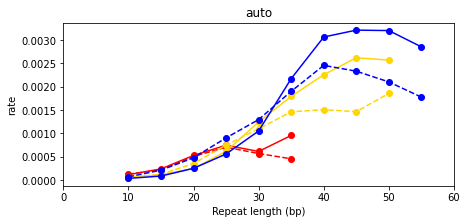

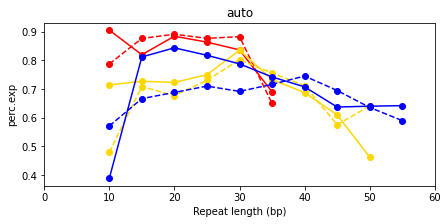

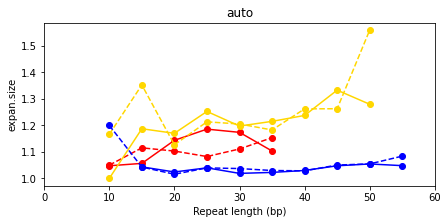

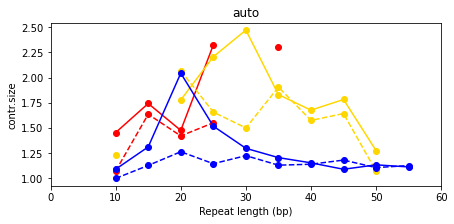

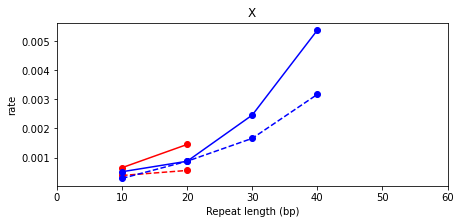

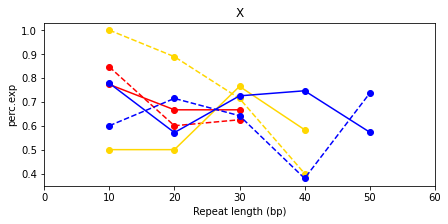

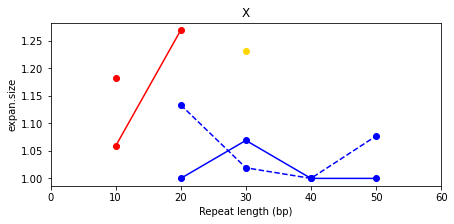

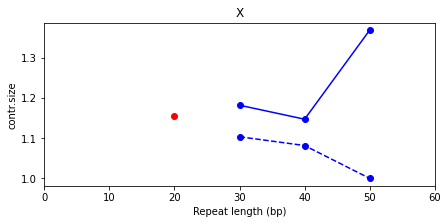

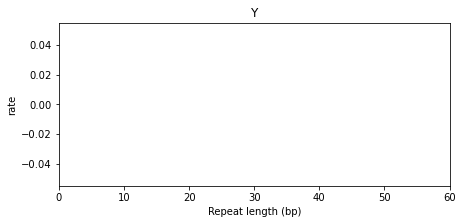

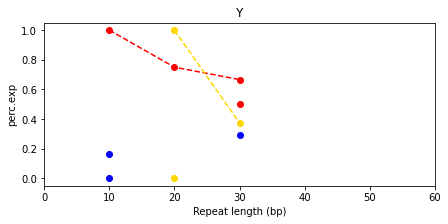

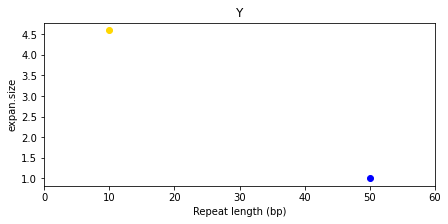

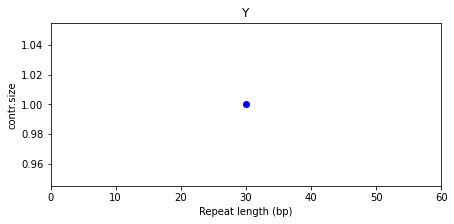

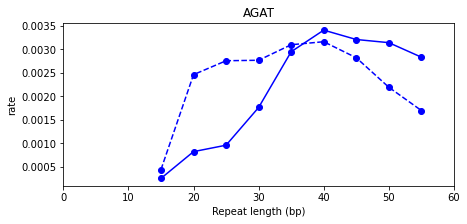

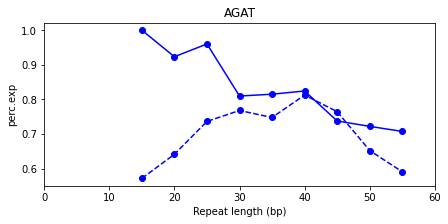

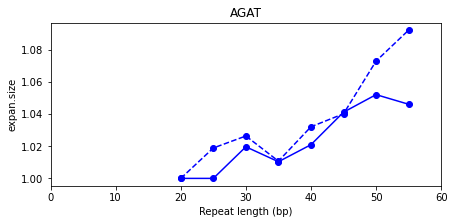

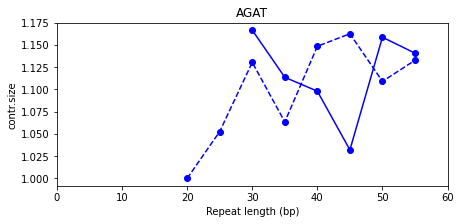

In [131]:
# Look at mutation rate/size/direction by rpt unit length/total length/BD

#### global plotting variables
percolors = {
    2: "red", 3: "gold", 4: "blue"
}

numstrains = 151

#### Plot separately for auto/x/y
for chrset in ["auto", "X","Y","AGAT"]:
    #### First, get list of each genotyped locus and number/type of mutations
    if chrset == "auto" or chrset == "AGAT":
        gt = pd.merge(gtloci[["chr","pos","end"]], motifAuto[["chr","pos","end","motif"]])
        df = dAuto
        thresh = 100
        window = 5
        lbins = np.arange(10, 60, window)
        if chrset == "AGAT":
            gt = gt[gt["motif"]=="AGAT"]
            df = df[df["motif"]=="AGAT"]
    elif chrset == "X":
        gt = pd.merge(gtlociX[["chr","pos","end"]], motifXY[["chr","pos","end","motif"]])
        gt = gt[gt["chr"] =="chrX"]
        df = dX
        thresh = 25
        window = 10
        lbins = np.arange(10, 60, window)
    else:
        gt = pd.merge(gtlociY[["chr","pos","end"]], motifXY[["chr","pos","end","motif"]])
        gt = gt[gt["chr"] =="chrY"]
        df = dY
        thresh = 25
        window = 10
        lbins = np.arange(10, 60, window)
    df["length"] = df["end"]-df["pos"]+1
    df["period"] = df["motif"].apply(len)
    gt_B = gt[["chr","pos","end","motif"]].copy()
    gt_D = gt[["chr","pos","end","motif"]].copy()
    gt_B["founder"] = "B"
    gt_D["founder"] = "D"

    mutsum = df.groupby(["chr","pos","end","founder"], as_index=False).agg({"strain": len, 
                                                                           "delta_fou": lambda x: list(x),
                                                                           "expand_type": lambda x: np.mean([item=="expan" for item in x]),
                                                                        "motif": lambda x: x.values[0]})
    mutsum = pd.merge(mutsum, pd.concat([gt_B, gt_D]), how="right").fillna(0)
    mutsum["length"] = mutsum["end"]-mutsum["pos"]+1
    mutsum["period"] = mutsum["motif"].apply(len)

    for metric in ["rate","perc.exp","expan.size","contr.size"]:
        fig = plt.figure()
        fig.set_size_inches((7, 3))
        ax = fig.add_subplot(111)
        for period in range(2, 5):
            for fou in ["B","D"]:
                ##### Compute the metric ######
                rates = []
                for lb in lbins:
                    if metric == "rate":
                        xx = mutsum[(mutsum["length"]>lb) & (mutsum["length"]<=lb+window) & 
                            (mutsum["period"]==period) &
                            (mutsum["founder"]==fou)].copy()
                        if xx.shape[0] < 100:
                            rates.append(np.nan)
                        else:
                            total_obs = xx.shape[0]*numstrains
                            total_mut = np.sum(xx["strain"])
                            rates.append(total_mut/total_obs)
                    elif metric == "perc.exp":
                        xx = mutsum[(mutsum["length"]>lb) & (mutsum["length"]<=lb+window) & 
                            (mutsum["period"]==period) &
                            (mutsum["founder"]==fou)].copy()
                        if xx.shape[0] < thresh:
                            rates.append(np.nan)
                        else:
                            num_exp = np.sum(xx.apply(lambda x: x["strain"]*x["expand_type"], 1))
                            num_total = np.sum(xx["strain"])
                            rates.append(num_exp/num_total)
                    elif metric == "expan.size":
                        sizes = list(df[(df["length"]>lb) & (df["length"]<=lb+window) &
                             (df["period"]==period) & (df["founder"]==fou) &
                             (df["expand_type"]=="expan")]["delta_fou"])
                        if len(sizes)<10:
                            rates.append(np.nan)
                        else: rates.append(np.mean(sizes))
                    elif metric == "contr.size":
                        sizes = list(df[(df["length"]>lb) & (df["length"]<=lb+window) &
                             (df["period"]==period) & (df["founder"]==fou) &
                             (df["expand_type"]!="expan")]["delta_fou"])
                        if len(sizes)<10:
                            rates.append(np.nan)
                        else: rates.append(np.mean(sizes))       
                if fou == "B": 
                    style = "solid"
                else: style = "dashed"
                ax.plot(lbins, rates, color=percolors[period], linestyle=style, label="%s-%s"%(period, fou), marker="o")
            #ax.legend()
            ax.set_xlim(left=0, right=60)
            ax.set_xlabel("Repeat length (bp)")
            ax.set_ylabel(metric)
            ax.set_title(chrset)

In [142]:
mutsum = dAuto.groupby(["chr","pos","end","founder"], as_index=False).agg({"strain": len, 
                                                                           "delta_fou": lambda x: list(x),
                                                                           "expand_type": lambda x: np.mean([item=="expan" for item in x]),
                                                                        "motif": lambda x: x.values[0]})
mutsum = pd.merge(mutsum, pd.concat([gt_B, gt_D]), how="right").fillna(0)
mutsum["length"] = mutsum["end"]-mutsum["pos"]+1
mutsum["period"] = mutsum["motif"].apply(len)

gt = pd.merge(gtloci[["chr","pos","end"]], motifAuto[["chr","pos","end","motif"]])
gt_B = gt[["chr","pos","end","motif"]].copy()
gt_D = gt[["chr","pos","end","motif"]].copy()
gt_B["founder"] = "B"
gt_D["founder"] = "D"
mutsum = pd.merge(mutsum, pd.concat([gt_B, gt_D]), how="right").fillna(0)

mutsum["num.exp"] = mutsum.apply(lambda x: x["expand_type"]*x["strain"], 1)
bymotif = mutsum.groupby(["motif","founder"], as_index=False).agg({"strain": np.sum, "period": len,
                                                                  "num.exp": np.sum})
bymotif = bymotif[bymotif["period"]>=500]
bymotif["perc.exp"] = bymotif.apply(lambda x: x["num.exp"]/x["strain"], 1)
bymotif["num.total"] = bymotif["period"]*numstrains
bymotif["rate"] = bymotif.apply(lambda x: x["strain"]*1.0/x["num.total"], 1)

bymotif_combined = bymotif.groupby("motif", as_index=False).agg({"rate": np.mean, "strain": np.sum})
bymotif_combined = bymotif_combined.sort_values("rate", ascending=False).head(n=25)
bymotif_combined["rate_avg"] = bymotif_combined["rate"]
bymotif_combined["total"] = bymotif_combined["strain"]

bymotif = pd.merge(bymotif, bymotif_combined[["motif","rate_avg", "total"]], on=["motif"]).sort_values(["rate_avg","founder"], ascending=[False, True])

def GetBinomialErr(k, n, z=1.96):
    p = k/n
    return z*np.sqrt(p*(1-p)/n)

bymotif["rate.err"] = bymotif.apply(lambda x: GetBinomialErr(x["strain"], x["num.total"]), 1)
bymotif["perc.exp.err"] = bymotif.apply(lambda x: GetBinomialErr(x["num.exp"], x["strain"]), 1)


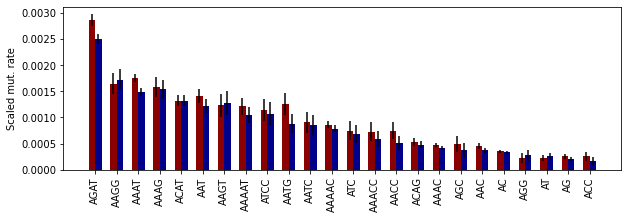

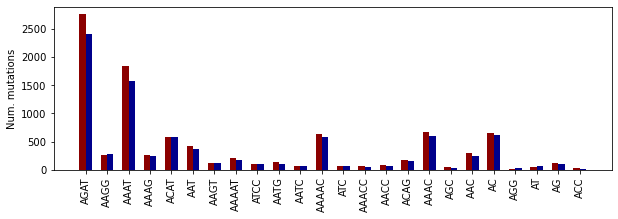

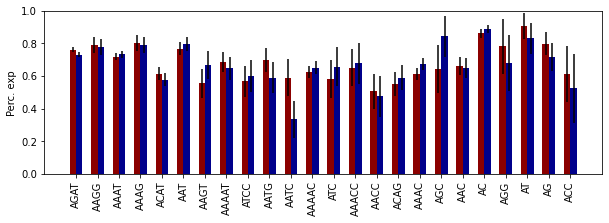

In [145]:
fig = plt.figure()
fig.set_size_inches((10, 3))
ax = fig.add_subplot(111)
ax.bar(range(int(bymotif.shape[0]/2)), bymotif[bymotif["founder"]=="B"]["rate"], 
       yerr = bymotif[bymotif["founder"]=="B"]["rate.err"],
       width=0.3, color="darkred")
ax.bar([item+0.3 for item in range(int(bymotif.shape[0]/2))], bymotif[bymotif["founder"]=="D"]["rate"], 
       yerr = bymotif[bymotif["founder"]=="D"]["rate.err"],
       width=0.3, color="darkblue")
ax.set_xticks([item+0.15 for item in range(int(bymotif.shape[0]/2))])
ax.set_xticklabels( bymotif[bymotif["founder"]=="B"]["motif"], rotation=90)
ax.set_ylabel("Scaled mut. rate")

fig = plt.figure()
fig.set_size_inches((10, 3))
ax = fig.add_subplot(111)
ax.bar(range(int(bymotif.shape[0]/2)), bymotif[bymotif["founder"]=="B"]["strain"], width=0.3, color="darkred")
ax.bar([item+0.3 for item in range(int(bymotif.shape[0]/2))], bymotif[bymotif["founder"]=="D"]["strain"], 
       width=0.3, color="darkblue")
ax.set_xticks([item+0.15 for item in range(int(bymotif.shape[0]/2))])
ax.set_xticklabels( bymotif[bymotif["founder"]=="B"]["motif"], rotation=90)
ax.set_ylabel("Num. mutations")

fig = plt.figure()
fig.set_size_inches((10, 3))
ax = fig.add_subplot(111)
ax.bar(range(int(bymotif.shape[0]/2)), bymotif[bymotif["founder"]=="B"]["perc.exp"], 
       yerr = bymotif[bymotif["founder"]=="B"]["perc.exp.err"], 
       width=0.3, color="darkred")
ax.bar([item+0.3 for item in range(int(bymotif.shape[0]/2))], bymotif[bymotif["founder"]=="D"]["perc.exp"], 
       yerr = bymotif[bymotif["founder"]=="D"]["perc.exp.err"], 
       width=0.3, color="darkblue")
ax.set_ylim(bottom=0.0, top=1.0)
ax.set_xticks([item+0.15 for item in range(int(bymotif.shape[0]/2))])
ax.set_xticklabels( bymotif[bymotif["founder"]=="B"]["motif"], rotation=90)
ax.set_ylabel("Perc. exp");
#bymotif

# Explore auto/X/Y

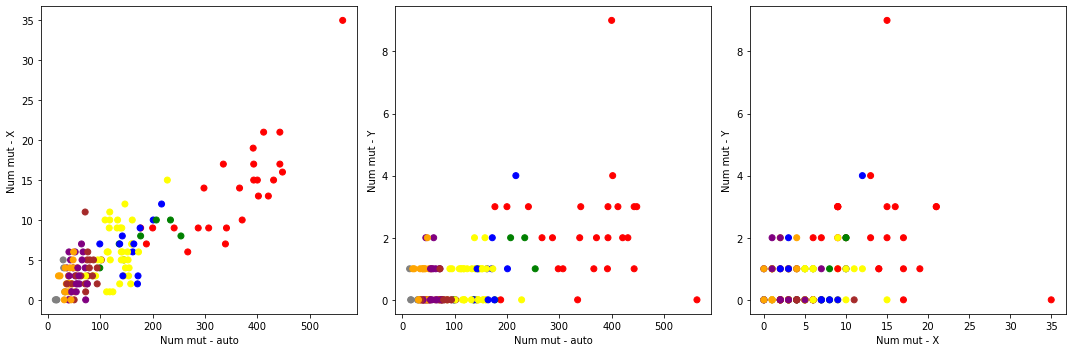

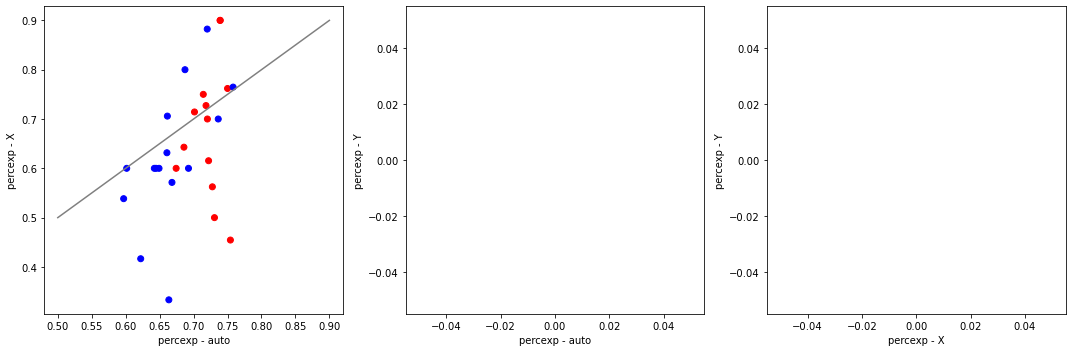

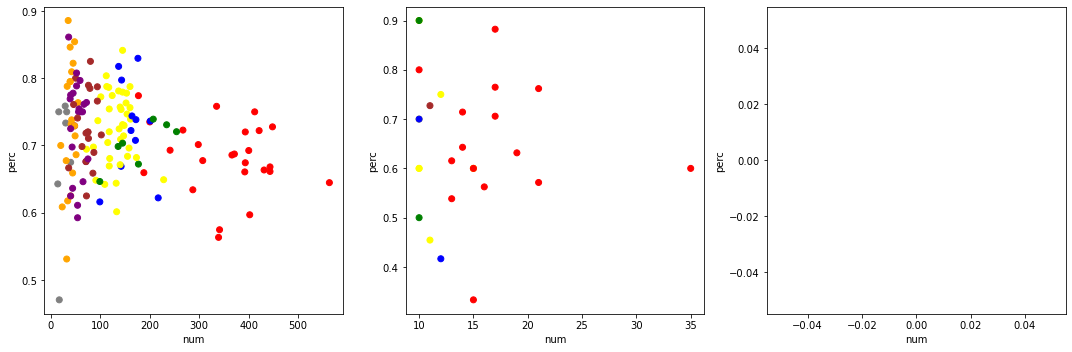

In [60]:
########### Scatter plot of strain auto/X/Y mutation phenotypes ########
MINMUT = 10

# Look at num auto vs. num X vs. num Y for each strain
strains = list(set(dAuto["strain"]))
scolors = []
fcolors = []
numX = []
numY = []
numAuto = []
percX = []
percY = []
percAuto = []

for s in strains:
    numX.append(dX[dX["strain"]==s].shape[0])
    numY.append(dY[dY["strain"]==s].shape[0])
    numAuto.append(dAuto[dAuto["strain"]==s].shape[0])
    if numX[-1]>=MINMUT:
        percX.append(np.mean(dX[dX["strain"]==s]["expand_sign"]>0))
    else: percX.append(float("nan"))
    if numY[-1]>=MINMUT:
        percY.append(np.mean(dY[dY["strain"]==s]["expand_sign"]>0))
    else: percY.append(float("nan"))
    if numAuto[-1]>=MINMUT:
        percAuto.append(np.mean(dAuto[dAuto["strain"]==s]["expand_sign"]>0))
    else: percAuto.append(float("nan"))
    scolors.append(ecolors[strain_epoch[strain_epoch["bxd_id"]==s]["off_epoch"].values[0]])
    fcolors.append({"B": "red", "D": "blue"}[strain_epoch[strain_epoch["bxd_id"]==s]["fou_gt"].values[0]])
    
######## Plot comparisons - num muts
usecolors = scolors
fig = plt.figure()
fig.set_size_inches((15, 5))
ax = fig.add_subplot(1, 3, 1)
ax.scatter(numAuto, numX, color=usecolors)
ax.set_xlabel("Num mut - auto")
ax.set_ylabel("Num mut - X")

ax = fig.add_subplot(1, 3, 2)
ax.scatter(numAuto, numY, color=usecolors)
ax.set_xlabel("Num mut - auto")
ax.set_ylabel("Num mut - Y")

ax = fig.add_subplot(1, 3, 3)
ax.scatter(numX, numY, color=usecolors)
ax.set_xlabel("Num mut - X")
ax.set_ylabel("Num mut - Y")

fig.tight_layout()

######## Plot comparisons - perc exp
usecolors = fcolors
fig = plt.figure()
fig.set_size_inches((15, 5))
ax = fig.add_subplot(1, 3, 1)
ax.scatter(percAuto, percX, color=usecolors)
ax.plot([0.5, 0.9], [0.5, 0.9], color="gray")
ax.set_xlabel("percexp - auto")
ax.set_ylabel("percexp - X")

ax = fig.add_subplot(1, 3, 2)
ax.scatter(percAuto, percY, color=usecolors)
ax.set_xlabel("percexp - auto")
ax.set_ylabel("percexp - Y")

ax = fig.add_subplot(1, 3, 3)
ax.scatter(percX, percY, color=usecolors)
ax.set_xlabel("percexp - X")
ax.set_ylabel("percexp - Y")

fig.tight_layout()

######## Are num total and perc exp related?
usecolors = scolors
fig = plt.figure()
fig.set_size_inches((15, 5))
ax = fig.add_subplot(1, 3, 1)
ax.scatter(numAuto, percAuto, color=usecolors)
ax.set_xlabel("num")
ax.set_ylabel("perc")

ax = fig.add_subplot(1, 3, 2)
ax.scatter(numX, percX, color=usecolors)
ax.set_xlabel("num")
ax.set_ylabel("perc")

ax = fig.add_subplot(1, 3, 3)
ax.scatter(numY, percY, color=usecolors)
ax.set_xlabel("num")
ax.set_ylabel("perc")

fig.tight_layout()

# B vs D for X, Y, autosomes

Stats for ML=all
Auto: n_B=18172, n_D=16898, p=1.3798641684307763e-32
chrX: n_B=474, n_D=431, p=0.19908807568012588
chrY: n_B=49, n_D=67, p=0.24580353693532409
Stats for ML=4
Auto: n_B=12959, n_D=12085, p=1.1485636660221669e-34
chrX: n_B=329, n_D=300, p=0.7678760205659186
chrY: n_B=25, n_D=35, p=0.16160065002674062


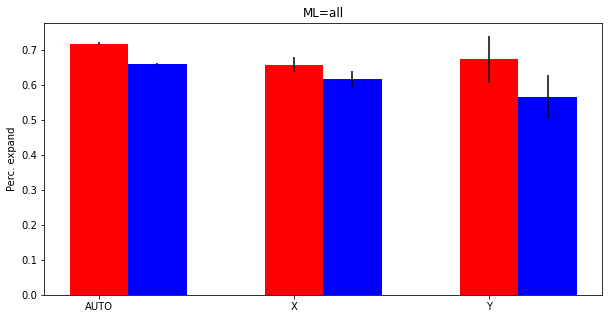

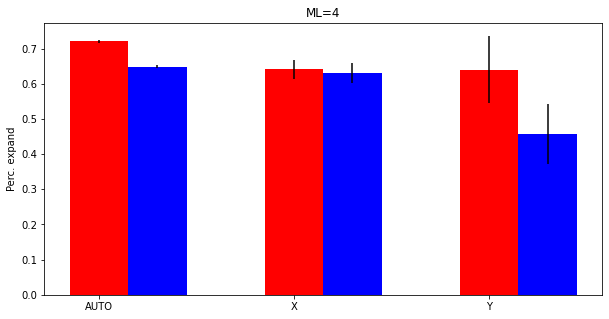

In [295]:
MINMUT = 10

def MatchesEpoch(off_epoch, epoch):
    if epoch == "ALL": return True
    return epoch==off_epoch

def GetSE(expsigns):
    p = np.mean(expsigns)
    n = len(expsigns)
    return np.sqrt(p*(1-p)/n)

# TODO: z-test proportions pvalue

# Plot B vx. D perc exp for all and by epoch
for ML in ["all", 4]:
    if ML != "all":
        useAuto = dAuto[dAuto["motif_len"]==ML]
        useX = dX[dX["motif_len"]==ML]
        useY = dY[dY["motif_len"]==ML]
    else:
        useAuto = dAuto
        useX = dX
        useY = dY
        
    fig = plt.figure()
    fig.set_size_inches((10, 5))
    ax = fig.add_subplot(111)
    ax.set_title("ML=%s"%ML)
    
    # ALL
    start = 0
    use_epochs = ["ALL"]
    xticks = []
    for epoch in use_epochs:
        xxAutoB = useAuto[(useAuto["fou_gt_y"]=="B") & 
                                 MatchesEpoch(useAuto["off_epoch"], epoch)]
        xxAutoD = useAuto[(useAuto["fou_gt_y"]=="D") & 
                                 MatchesEpoch(useAuto["off_epoch"], epoch)]
        if xxAutoB.shape[0] > MINMUT and xxAutoD.shape[0] > MINMUT:
            auto_B = np.mean(xxAutoB["expand_sign"]>0)
            auto_D = np.mean(xxAutoD["expand_sign"]>0)
            auto_B_err = GetSE(xxAutoB["expand_sign"]>0)
            auto_D_err = GetSE(xxAutoD["expand_sign"]>0)
        else:
            auto_B = np.nan
            auto_D = np.nan
            auto_B_err = np.nan
            auto_D_err = np.nan
            
        xxXB = useX[(useX["fou_gt_y"]=="B") & 
                        MatchesEpoch(useX["off_epoch"], epoch)]
        xxXD = useX[(useX["fou_gt_y"]=="D") & 
                        MatchesEpoch(useX["off_epoch"], epoch)]
        if xxXB.shape[0] > MINMUT and xxXD.shape[0] > MINMUT:
            X_B = np.mean(xxXB["expand_sign"]>0)
            X_D = np.mean(xxXD["expand_sign"]>0)
            X_B_err = GetSE(xxXB["expand_sign"]>0)
            X_D_err = GetSE(xxXD["expand_sign"]>0)
        else:
            X_B = np.nan
            X_D = np.nan
            X_B_err = np.nan
            X_D_err = np.nan

        xxYB = useY[(useY["fou_gt_y"]=="B") & 
                        MatchesEpoch(useY["off_epoch"], epoch)]
        xxYD = useY[(useY["fou_gt_y"]=="D") & 
                        MatchesEpoch(useY["off_epoch"], epoch)]
        if xxYB.shape[0] > MINMUT and xxYD.shape[0] > MINMUT:
            Y_B = np.mean(xxYB["expand_sign"]>0)
            Y_D = np.mean(xxYD["expand_sign"]>0)
            Y_B_err = GetSE(xxYB["expand_sign"]>0)
            Y_D_err = GetSE(xxYD["expand_sign"]>0)
        else:
            Y_B = np.nan
            Y_D = np.nan
            Y_B_err = np.nan
            Y_D_err = np.nan
        
        xvals = range(start, start+3)
        ax.bar(xvals, [auto_B, X_B, Y_B], color="red", yerr=[auto_B_err, X_B_err, Y_B_err], width=0.3)
        ax.bar([item+0.3 for item in xvals], [auto_D, X_D, Y_D],  yerr=[auto_D_err, X_D_err, Y_D_err], color="blue", width=0.3)
        xticks.extend(xvals)
        start += 4
        
        # Compute pvalues
        print("Stats for ML=%s"%ML)
        print("Auto: n_B=%s, n_D=%s, p=%s"%(xxAutoB.shape[0], xxAutoD.shape[0],
                                           proportions_ztest([np.sum(xxAutoB["expand_sign"]>0), 
                                                             np.sum(xxAutoD["expand_sign"]>0)], 
                                                             [xxAutoB.shape[0], xxAutoD.shape[0]])[1]))
        print("chrX: n_B=%s, n_D=%s, p=%s"%(xxXB.shape[0], xxXD.shape[0],
                                           proportions_ztest([np.sum(xxXB["expand_sign"]>0), 
                                                             np.sum(xxXD["expand_sign"]>0)], 
                                                             [xxXB.shape[0], xxXD.shape[0]])[1]))
        print("chrY: n_B=%s, n_D=%s, p=%s"%(xxYB.shape[0], xxYD.shape[0],
                                           proportions_ztest([np.sum(xxYB["expand_sign"]>0), 
                                                             np.sum(xxYD["expand_sign"]>0)], 
                                                             [xxYB.shape[0], xxYD.shape[0]])[1]))
    ax.set_xticks(xticks)
    ax.set_xticklabels(["AUTO","X","Y"])
    ax.set_ylabel("Perc. expand")


## Test to check for diff Y > diff auto > diff X

- for each strain permute auto/x/y labels for the mutations
- compute *aggregate* values for the % expanded for auto/x/y in B/D 
- get (B_auto-D_auto)-(B_y-D_y)
- repeat to get a null distribution
- compare to the actual observed (B_auto-D_auto)-(B_y-D_y) 

In [62]:
alldfs = pd.concat([dAuto, dX, dY])
numsim = 100
auto_chroms = ["chr%s"%i for i in range(1, 20)]

def PermuteChroms(chroms, strains):
    # Permute chroms within each strain
    perm_chroms = [None]*len(chroms)
    allstrains = set(strains)
    for s in allstrains:
        strain_indices = [i for i in range(len(strains)) if strains[i]==s]
        strain_chroms = [chroms[i] for i in strain_indices]
        random.shuffle(strain_chroms)
        j = 0
        for i in strain_indices:
            perm_chroms[i] = strain_chroms[j]
            j += 1
    return perm_chroms
    
diffs_auto_X = []
diffs_X_Y = []
diffs_auto_Y = []

# Get observed
p_auto_B = np.mean(alldfs[(alldfs["chr"].isin(auto_chroms)) & (alldfs["fou_gt_y"]=="B")]["expand_sign"]>0)
p_auto_D = np.mean(alldfs[(alldfs["chr"].isin(auto_chroms)) & (alldfs["fou_gt_y"]=="D")]["expand_sign"]>0)
p_X_B = np.mean(alldfs[(alldfs["chr"].isin(["chrX"])) & (alldfs["fou_gt_y"]=="B")]["expand_sign"]>0)
p_X_D = np.mean(alldfs[(alldfs["chr"].isin(["chrX"])) & (alldfs["fou_gt_y"]=="D")]["expand_sign"]>0)
p_Y_B = np.mean(alldfs[(alldfs["chr"].isin(["chrY"])) & (alldfs["fou_gt_y"]=="B")]["expand_sign"]>0)
p_Y_D = np.mean(alldfs[(alldfs["chr"].isin(["chrY"])) & (alldfs["fou_gt_y"]=="D")]["expand_sign"]>0)
obs_diff_auto = p_auto_B-p_auto_D
obs_diff_X = p_X_B-p_X_D
obs_diff_Y = p_Y_B-p_Y_D
obs_diffs_auto_X = obs_diff_auto - obs_diff_X
obs_diffs_X_Y = obs_diff_X - obs_diff_Y
obs_diffs_auto_Y = obs_diff_auto -  obs_diff_Y

for i in range(numsim):
    alldfs["chr_permute"] = PermuteChroms(list(alldfs["chr"]), list(alldfs["strain"]))
    p_auto_B = np.mean(alldfs[(alldfs["chr_permute"].isin(auto_chroms)) & (alldfs["fou_gt_y"]=="B")]["expand_sign"]>0)
    p_auto_D = np.mean(alldfs[(alldfs["chr_permute"].isin(auto_chroms)) & (alldfs["fou_gt_y"]=="D")]["expand_sign"]>0)
    p_X_B = np.mean(alldfs[(alldfs["chr_permute"].isin(["chrX"])) & (alldfs["fou_gt_y"]=="B")]["expand_sign"]>0)
    p_X_D = np.mean(alldfs[(alldfs["chr_permute"].isin(["chrX"])) & (alldfs["fou_gt_y"]=="D")]["expand_sign"]>0)
    p_Y_B = np.mean(alldfs[(alldfs["chr_permute"].isin(["chrY"])) & (alldfs["fou_gt_y"]=="B")]["expand_sign"]>0)
    p_Y_D = np.mean(alldfs[(alldfs["chr_permute"].isin(["chrY"])) & (alldfs["fou_gt_y"]=="D")]["expand_sign"]>0)

    diff_auto = p_auto_B-p_auto_D
    diff_X = p_X_B-p_X_D
    diff_Y = p_Y_B-p_Y_D
    diffs_auto_X.append(diff_auto-diff_X)
    diffs_X_Y.append(diff_X - diff_Y)
    diffs_auto_Y.append(diff_auto-diff_Y)


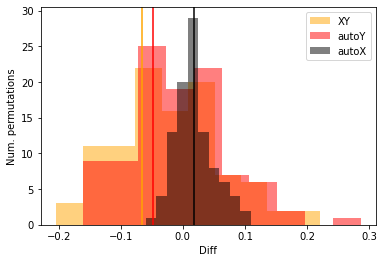

In [285]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(diffs_X_Y, label="XY", color="orange", alpha=0.5)
ax.axvline(obs_diffs_X_Y, color="orange")

ax.hist(diffs_auto_Y, label="autoY", color="red", alpha=0.5)
ax.axvline(obs_diffs_auto_Y, color="red")

ax.hist(diffs_auto_X, label="autoX", color="black", alpha=0.5)
ax.axvline(obs_diffs_auto_X, color="black")

ax.legend();
ax.set_xlabel("Diff")
ax.set_ylabel("Num. permutations");

# Is the difference dependent on STR length?

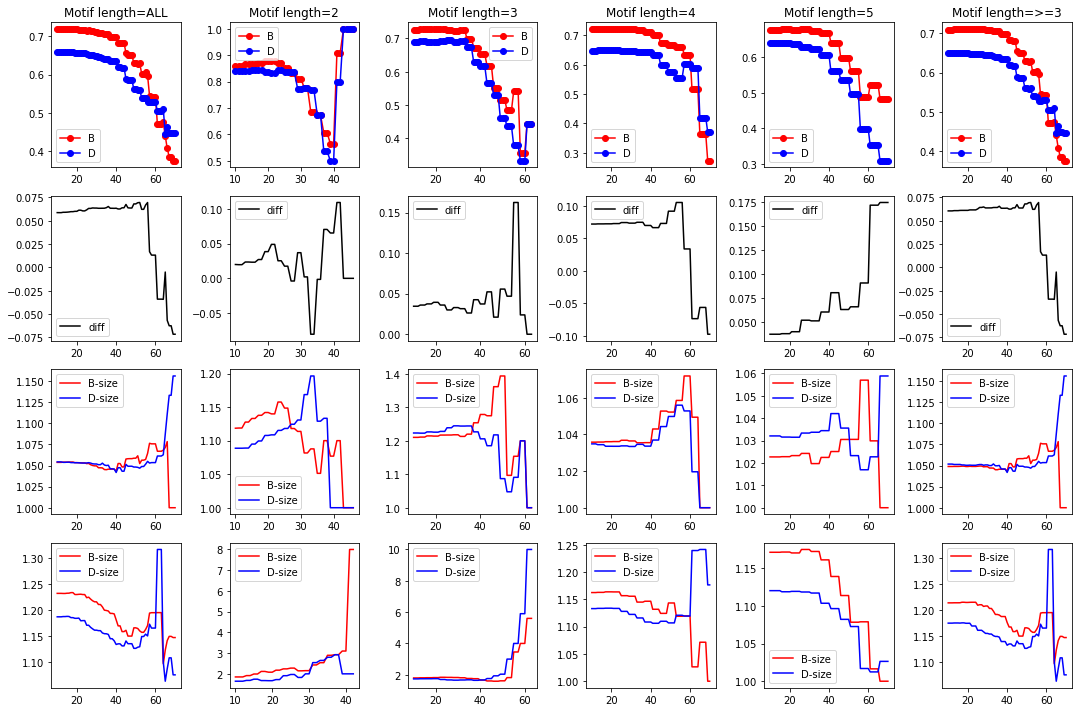

In [298]:
dAuto["length"] = dAuto["end"]-dAuto["pos"]+1

lthreshs = np.arange(10, 71, 1)

fig = plt.figure()
fig.set_size_inches((15, 10))
colind = 1
for ML in ["ALL", 2, 3, 4, 5, ">=3"]:
    pbs = []
    pds = []
    sizesB_exp = []
    sizesD_exp = []
    sizesB_contr = []
    sizesD_contr = []
    
    for lthresh in lthreshs:
        if ML == "ALL":
            data = dAuto[(dAuto["length"]>=lthresh)]
        elif ML == ">=3":
            data = dAuto[(dAuto["length"]>=lthresh) & (dAuto["motif_len"]>=3)]
        else: 
            data = dAuto[(dAuto["length"]>=lthresh) & (dAuto["motif_len"]==ML)]
        #print(data.shape[0])
        p_B = np.mean(data[data["fou_gt_y"]=="B"]["expand_sign"]>0)
        p_D = np.mean(data[data["fou_gt_y"]=="D"]["expand_sign"]>0)
        pbs.append(p_B)
        pds.append(p_D)
        sizesB_exp.append(np.mean(data[(data["fou_gt_y"]=="B")&(data["expand_sign"]>0)]["delta_fou"]))
        sizesD_exp.append(np.mean(data[(data["fou_gt_y"]=="D")&(data["expand_sign"]>0)]["delta_fou"]))
        sizesB_contr.append(np.mean(data[(data["fou_gt_y"]=="B")&(data["expand_sign"]<0)]["delta_fou"]))
        sizesD_contr.append(np.mean(data[(data["fou_gt_y"]=="D")&(data["expand_sign"]<0)]["delta_fou"]))
        
    ax = fig.add_subplot(4, 6, colind)
    ax.set_title("Motif length=%s"%ML)
    ax.plot(lthreshs, pbs, color="red", marker="o", label="B")
    ax.plot(lthreshs, pds, color="blue", marker="o", label="D")
    ax.legend();

    ax = fig.add_subplot(4, 6, colind+6)
    ax.plot(lthreshs, [pbs[i]-pds[i] for i in range(len(lthreshs))], color="black", label="diff")
    #ax.axhline(y=0, color="gray")
    ax.legend();
    
    ax = fig.add_subplot(4, 6, colind+12)
    ax.plot(lthreshs, sizesB_exp, color="red", label="B-size")
    ax.plot(lthreshs, sizesD_exp, color="blue", label="D-size")
    ax.legend();
    
    ax = fig.add_subplot(4, 6, colind+18)
    ax.plot(lthreshs, sizesB_contr, color="red", label="B-size")
    ax.plot(lthreshs, sizesD_contr, color="blue", label="D-size")
    ax.legend();
    
    colind += 1
    
fig.tight_layout()

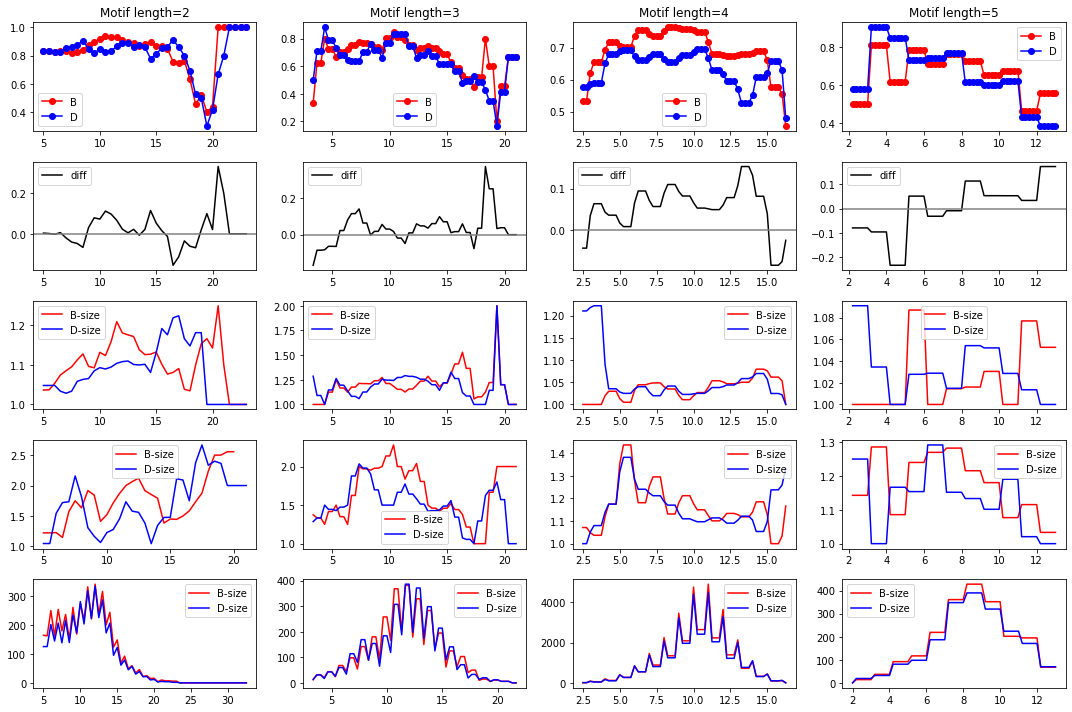

In [287]:
dAuto["length"] = dAuto["end"]-dAuto["pos"]+1

lthreshs = np.arange(10, 66, 1)
binsize = 5
maxmutsize = 5

motifs = [2, 3, 4, 5]
numcol = len(motifs)
fig = plt.figure()
fig.set_size_inches((15, 10))
colind = 1
for ML in motifs:
    pbs = []
    pds = []
    sizesB_exp = []
    sizesD_exp = []
    sizesB_contr = []
    sizesD_contr = []
    numB = []
    numD = []
    
    for lthresh in lthreshs:
        if ML == "ALL":
            data = dAuto[(dAuto["length"]>=lthresh) & (dAuto["length"]<lthresh+binsize) & (dAuto["delta_fou"].apply(abs)<=maxmutsize)]
        elif ML == ">=3":
            data = dAuto[(dAuto["length"]>=lthresh) & (dAuto["length"]<lthresh+binsize) & (dAuto["delta_fou"].apply(abs)<=maxmutsize)& (dAuto["motif_len"]>=3)]
        else: 
            data = dAuto[(dAuto["length"]>=lthresh) & (dAuto["length"]<lthresh+binsize) & (dAuto["delta_fou"].apply(abs)<=maxmutsize)& (dAuto["motif_len"]==ML)]
        #print(data.shape[0])
        p_B = np.mean(data[data["fou_gt_y"]=="B"]["expand_sign"]>0)
        p_D = np.mean(data[data["fou_gt_y"]=="D"]["expand_sign"]>0)
        pbs.append(p_B)
        pds.append(p_D)
        sizesB_exp.append(np.mean(data[(data["fou_gt_y"]=="B")&(data["expand_sign"]>0)]["delta_fou"]))
        sizesD_exp.append(np.mean(data[(data["fou_gt_y"]=="D")&(data["expand_sign"]>0)]["delta_fou"]))
        sizesB_contr.append(np.mean(data[(data["fou_gt_y"]=="B")&(data["expand_sign"]<0)]["delta_fou"]))
        sizesD_contr.append(np.mean(data[(data["fou_gt_y"]=="D")&(data["expand_sign"]<0)]["delta_fou"]))
        numB.append(data[data["fou_gt_y"]=="B"].shape[0])
        numD.append(data[data["fou_gt_y"]=="D"].shape[0])
        
    ax = fig.add_subplot(5, numcol, colind)
    ax.set_title("Motif length=%s"%ML)
    ax.plot([item/ML for item in lthreshs], pbs, color="red", marker="o", label="B")
    ax.plot([item/ML for item in lthreshs], pds, color="blue", marker="o", label="D")
    ax.legend();

    ax = fig.add_subplot(5, numcol, colind+numcol)
    ax.plot([item/ML for item in lthreshs], [pbs[i]-pds[i] for i in range(len(lthreshs))], color="black", label="diff")
    ax.axhline(y=0, color="gray")
    ax.legend();
    
    ax = fig.add_subplot(5, numcol, colind+numcol*2)
    ax.plot([item/ML for item in lthreshs], sizesB_exp, color="red", label="B-size")
    ax.plot([item/ML for item in lthreshs], sizesD_exp, color="blue", label="D-size")
    ax.legend();
    
    ax = fig.add_subplot(5, numcol, colind+numcol*3)
    ax.plot([item/ML for item in lthreshs], sizesB_contr, color="red", label="B-size")
    ax.plot([item/ML for item in lthreshs], sizesD_contr, color="blue", label="D-size")
    ax.legend();

    ax = fig.add_subplot(5, numcol, colind+numcol*4)
    ax.plot([item/ML for item in lthreshs], numB, color="red", label="B-size")
    ax.plot([item/ML for item in lthreshs], numD, color="blue", label="D-size")
    ax.legend();

    colind += 1
    
fig.tight_layout()

# Logistic regression

exp/contr ~ Msh3(B or D) + numgen + length + auto/X/Y # logistic regression


In [92]:
import statsmodels.api as sm

# Get alld fs
alldfs = pd.concat([dAuto, dX, dY])
alldfs = alldfs[~np.isnan(alldfs["gen_inbreeding"])]
alldfs["length"] = alldfs["end"]-alldfs["pos"]+1
alldfs["period"] = alldfs["motif"].apply(len)

# Get vars
alldfs["fou"] = (alldfs["fou_gt_y"]=="B").apply(int)
alldfs["chrX"] = (alldfs["chr"]=="chrX").apply(int)
alldfs["chrY"] = (alldfs["chr"]=="chrY").apply(int)
alldfs["auto"] = (alldfs["chr"].apply(lambda x: x not in ["chrX","chrY"])).apply(int)

# interaction term
alldfs["BX"] = alldfs.apply(lambda x: x["chrX"]*x["fou"], 1)
alldfs["BY"] = alldfs.apply(lambda x: x["chrY"]*x["fou"], 1)

ds = alldfs#[(alldfs["period"]==4)]

X = ds[["fou", "length", "gen_inbreeding", "auto","chrX","chrY","BX","BY"]]
Y = list((ds["expand_sign"]>0).apply(int))

mod = sm.Logit(Y,X)
fii = mod.fit()
summary = fii.summary2()
summary

Optimization terminated successfully.
         Current function value: 0.596369
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.016     
Dependent Variable: y                AIC:              25052.7481
Date:               2022-10-12 22:03 BIC:              25116.3629
No. Observations:   20991            Log-Likelihood:   -12518.   
Df Model:           7                LL-Null:          -12728.   
Df Residuals:       20983            LLR p-value:      2.1327e-86
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
fou               0.2008   0.0326   6.1594 0.0000  0.1369  0.2647
length           -0.0248   0.0014 -17.8224 0.0000 -0.0275 -0.0220
gen_inbreeding   -0.0009   0.0003  -3.2249 0.0013 -0.0014 -0.0003
auto              1.8764   0.0685  27.4006 0.0000  1.7422  2.0106
chrX              1.5654   0.1200  13.0435 0.0000  1.3302  1.8006
chrY              1.0883   0.2624   4.1467 0.0000  0.5739  1.6026
BX               -0.0380   0.1445  -0.2628 0.7927 -0.3213  0.2453
BY                0.4623   0.4043   1.1436 0.2528 -0.3301  1.2548
=================================================================

"""